数据准备是机器学习问题的关键一步，pytorch提供了许多工具可以方便的加载数据，使代码更易读。这个教程将学习怎么加载和处理数据集

需要用到的库：
- `scikit-image:` 图像读取和转换
- `pandas`: csv文件解析

In [4]:
from __future__ import print_function, division
import os 
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion() #交互模式，程序遇到plt.show()可以继续执行，不阻塞

[数据集下载](https://download.pytorch.org/tutorial/faces.zip), 实验用的数据集为人脸姿态估计，包含几张人脸图像和标注文件csv；  
首先读取csv文件并获取标注，标注为(N, 2)的数组，N表示标注点的数量

In [7]:
data_path = r"D:\SongZhenqi\dataset\faces" # 数据集地址

In [23]:
landmarks_frame = pd.read_csv(os.path.join(data_path, "face_landmarks.csv"))

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[:4])) # 输出前四张图的所有信息

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


编写一个简单的辅助函数用来显示图像和标注

In [26]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:,1], s=10, marker='.', c="r")
    plt.pause(0.001)

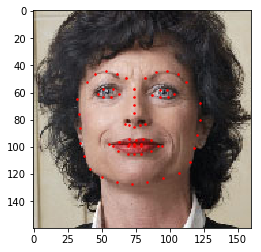

In [28]:
plt.figure()
show_landmarks(io.imread(os.path.join(data_path, img_name)), landmarks)
plt.show()

## Dataset 类

`torch.utils.data.Dataset`是一个表示数据集的抽象类。自定义的数据集需要集成`Dataset`并重载一下函数。
- \_\_len\_\_ , 使用len(dataset)返回数据集的大小
- \_\_getitem\_\_, 支持数据所用，dataset[i]

接下来创建自己的数据集类，在`__init__`中读取csv文件，在`__getitem__`中读取图像，这样不用将所有图像储存在内存中，而是需要的时候的读取。

数据集是一个词典类型` {'image': image, 'landmarks': landmarks}`。

In [31]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        csv_file: csv文件的路径
        root_dir：所有图像的路径
        transform： 样例的可选变换
        """
    
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # 根据索引值从csv数据中获取图像的路径
        img_name = os.path.join(self.root_dir,
                               self.landmarks_frame.iloc[idx, 0])
        # 读取图像数据
        image = io.imread(img_name)
        
        # 读取标注
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {"image": image, "landmarks":landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (324, 215, 3) (68, 2)


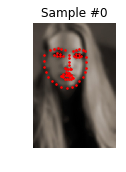

1 (500, 333, 3) (68, 2)


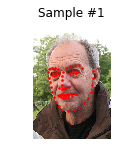

2 (250, 258, 3) (68, 2)


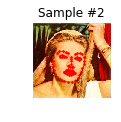

3 (434, 290, 3) (68, 2)


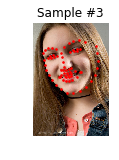

In [33]:
# 实例化数据集类，并读取数据

face_dataset = FaceLandmarksDataset(csv_file=os.path.join(data_path,
                                                         "face_landmarks.csv"),
                                   root_dir=data_path)
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

## Transforms

数据集的样本图像通常尺度不同，而许多网络要求输入的图像尺度统一，因此需要添加一些需处理代码统一尺寸。本处添加：

- `Rescale`: 缩放图像
- `RandomCrop`: 使用随机裁剪，增强数据集
- `ToTensor`：将图像数据转换为torch数据

需要将其写为`callable`形式的类，而不是简单的函数，这就要求重写`__call__`和`__init__`.

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

In [34]:
# 图像缩放
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample["landmarks"]
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w /h
        else:
            new_h, new_w = self.output_size        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # 根据缩放系数更新标注
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {"image":img, "landmarks":landmarks}

In [41]:
class RandomCrop(object):
    # 随机裁剪
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        
        if isinstance(output_size, int):
            self.output_size=(output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        img = image[top: top+new_h, left:left+new_w]
        landmarks = landmarks - [left, top]
        
        return {"image":img, "landmarks":landmarks}

In [61]:
class ToTensor(object):
    # 将数据转为Tensor
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
               "landmarks":torch.from_numpy(landmarks)}

### 组合变换

使用`torchvision.transforms.Compose`可以将多个变换组合起来

In [62]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                              RandomCrop(224)])

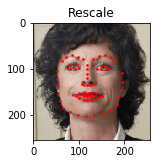

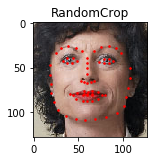

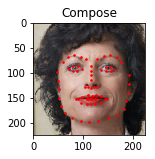

In [63]:
fig = plt.figure()
sample = face_dataset[65]

# 分别使用两种变换和组合变换
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

### 数据集迭代

将组合变换和数据集放在一起，每次对数据集采样都可以执行一下操作：
 - 即时从文件中读取数据
 - 对读取的图像进行变换操作
 - 每次的变换都是随机的，不同的，实现了数据集的扩充

数据的读取可以使用for循环迭代，但是这样的话：
- 无法批处理
- 无法随机读取
- 不能使用`multiprocessing`并行读取

`torch.utils.data.DataLoader`使可以提供以上特性的迭代器。其中`collate_fn`参数比较重要，它指定了一个batch数据的组成。

In [67]:
transformed_dataset = FaceLandmarksDataset(csv_file=os.path.join(data_path,
                                                         "face_landmarks.csv"),
                                           root_dir=data_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))


In [68]:
dataloader = DataLoader(transformed_dataset, 
                        batch_size=4,
                        shuffle=True,
                        num_workers=0)
# num_workers必须是0，这是bug，否则报错

In [77]:
def show_landmarks_batch(sample_batched):
    # 显示一个Batch的数据
    images_batch, landmarks_batch = sample_batched["image"], sample_batched["landmarks"]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                   landmarks_batch[i, :, 1].numpy() + grid_border_size,
                   s=10, marker=".", c="r")
        
        plt.title("Batch from dataloader")

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


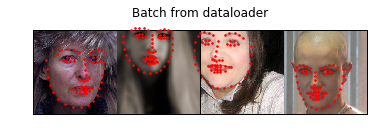

In [79]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched["image"].size(),
         sample_batched["landmarks"].size())
    
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis("off")
        plt.ioff()
        plt.show()
        break

### torchvision

torchvision包提供了一些通用的数据集和转换。
一些镜像，缩放等转换，已经提供了，不需要再自己重新实现。

```python
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
```